In [1]:
# CCS torque control with PI-regulated rotor circuit and RL-regulated stator circuit
import time
from typing import Tuple, Optional, List, Type

import gymnasium as gym
from matplotlib.pylab import seed
import numpy as np
import torch as th
import torch.nn as nn
import matplotlib.pyplot as plt

from gymnasium import ObservationWrapper
from gymnasium.wrappers import TimeLimit
from gymnasium.spaces import Box

from stable_baselines3 import DDPG, TD3
from stable_baselines3.common.policies import BaseModel
from stable_baselines3.common.preprocessing import get_action_dim
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.utils import update_learning_rate
from stable_baselines3.td3.policies import Actor, TD3Policy

import gym_electric_motor as gem
from gym_electric_motor.physical_systems import ConstantSpeedLoad
from gym_electric_motor.physical_system_wrappers import CosSinProcessor, DeadTimeProcessor, DqToAbcActionProcessor

from dq_to_abc_action_processor import DqToAbcActionProcessor # type: ignore
from gym_electric_motor.reference_generators import MultipleReferenceGenerator, ConstReferenceGenerator, \
      WienerProcessReferenceGenerator, StepReferenceGenerator
from gym_electric_motor import RewardFunction

from gym_electric_motor.utils import set_state_array
import warnings
from scipy import signal
import random
import pickle
from stable_baselines3.common.noise import NormalActionNoise
from typing import Callable
# import gem_controllers as gc

# import tensorboard

In [2]:
class PIController:
    def __init__(self, kp, ki, output_limits=(None, None)):
        self.kp = kp
        self.ki = ki
        self.output_min, self.output_max = output_limits
        self.integral = 0.0

    def control(self, measurement, ref, dt):
        error = ref - measurement
        self.integral += error * dt        
        PI_out = self.kp * error + self.ki * self.integral
        PI_out_array = np.clip(PI_out, self.output_min, self.output_max)
        return PI_out_array
    
    def reset(self):
        self.integral = 0

In [3]:
class DiscreteTransferFunction:
    def __init__(self):
        self.system_discrete = None
        self.step = 0
        # max epi length

    def discretize(self, num, den, dt):
        self.num = num
        self.den = den
        self.dt = dt
        # Discretize the continuous transfer function using bilinear transform
        self.system_discrete = signal.cont2discrete((self.num, self.den), self.dt, method='bilinear')
        self.num_discrete, self.den_discrete, self.dt_discrete = self.system_discrete[0], self.system_discrete[1], self.system_discrete[2]
        self.system = signal.dlti(self.num_discrete, self.den_discrete, dt=self.dt_discrete)
    
    def get_step_response(self):
        # n = max step, change n to get the no. of steps you want
        t, y = signal.dstep(self.system, n = 10000, t = [self.step * self.system.dt, (self.step+1) * self.system.dt]) #t = [self.step * self.system.dt, (self.step+1) * self.system.dt]
        t = np.squeeze(t)
        y = np.squeeze(y)
        self.step += 1
        return [t[-1]], [y[-1]]

    def plot_step_response(self):
        t, y = self.get_step_response()
        plt.figure()
        plt.stem(t, y)
        plt.title('Discrete Step Response')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.grid()
        plt.show()

    def reset(self):
        self.step = 0

In [4]:
class FeatureWrapper(ObservationWrapper):
    """
    Wrapper class which wraps the environment to change its observation from a tuple to a flat vector.
    """
    def __init__(self, env):
        """
        Changes the observation space from a tuple to a flat vector
        
        Args:
            env(GEM env): GEM environment to wrap
        """
        super(FeatureWrapper, self).__init__(env)
        state_space = self.env.observation_space[0]
        ref_space = self.env.observation_space[1]

        new_low = np.concatenate((state_space.low,
                                  ref_space.low))
        new_high = np.concatenate((state_space.high,
                                   ref_space.high))
    
        self.observation_space = Box(new_low, new_high)

    def observation(self, observation):
        """
        Gets called at each return of an observation.
        
        """
        observation = np.concatenate((observation[0],
                                      observation[1],
                                      ))
        # print(f"Obs_check \n {observation}")
        return observation

In [5]:
class LastActionWrapper(gym.Wrapper):
    def __init__(self, env):
        super(LastActionWrapper, self).__init__(env)
        state_space = self.env.observation_space
        # action_space = self.env.action_space

        action_dq = Box(np.array([-1, -1]), np.array([1, 1]))
        self.action_space = action_dq

        self.PI = PIController(kp = 1.4614e+3, ki = 2.3201e+6, output_limits = (-5e+3, 5e+3)) # second order, 500Hz
        self.LowPass = DiscreteTransferFunction()
        
        self.observation_space = Box(np.array([-1]*10), np.array([1]*10)) # hard coding, x10 because there are 10 states in obs vector
        # obs = ["i_sd", "i_sq", "omega", "i_e", "cos(epsilon)", "sin(epsilon)"], t ref, 3 actions

        self.step_counter = 0
        self.new_count = 0
        self.I_max = 6.25

# fill last action with zeros
    def reset(self, seed = 42, **kwargs):
        super().reset(seed = seed)
        self.PI.reset() # reset PI controller
        self.LowPass.reset()

        self.step_counter = 0
        self.new_count = 0
        self.ref_b4lp = [random.uniform(0.2, 0.8) * self.I_max for _ in range(2)] # randomly giving two if values
        self.change_time_step = random.randint(2000, 4000) # random changing time for if

        observation, info = self.env.reset(**kwargs)
        self.old_observation = observation
        self.last_action = np.zeros(3, dtype=np.float32)

        return np.concatenate((observation, self.last_action)), info

# put action to the last action
    def step(self, u_dq):
        
        I_max = 6.25
        U_max = 5e+3
        freq_lp = 10 # low pass frequency
      
        if self.step_counter < self.change_time_step:
            ref_b4lp = self.ref_b4lp[0]
            num = [ref_b4lp]  # Numerator coefficients for 1/(s+1)
            den = [1/(2*np.pi*freq_lp), 1]  # Denominator coefficients for 1/(s+1)
            dt = 0.0001  # Example: sampling time (seconds), same as converter switching frequency
            _ = self.LowPass.discretize(num, den, dt)
            __, lp_res = self.LowPass.get_step_response() 

        else:
            # to get low-pass behavior
            start_value = self.ref_b4lp[0]
            end_value = self.ref_b4lp[1]
            transient_steps = 1000
            total_steps = 6000 - self.change_time_step
            t_change = np.linspace(0, 1, transient_steps)  # Normalized time array from 0 to 1 for the first 1000 steps
            exponential_change = start_value + (end_value - start_value) * (1 - np.exp(-5 * t_change))
            values = np.concatenate((exponential_change, np.full(total_steps - transient_steps, end_value)))
            lp_res = np.array([values[self.new_count]])
            self.new_count += 1
        
        self.step_counter += 1
        # obs = ["i_sd", "i_sq", "omega", "i_e", "cos(epsilon)", "sin(epsilon)"], t ref, 3 actions
        meas = self.old_observation[3] * I_max
        u_e = self.PI.control(measurement = meas, ref = lp_res, dt = 0.0001)
        u_e_normalize = u_e/ U_max

        u_dq = u_dq /5000 * 200 # to limit stator value between DC link voltage
        action = np.concatenate((u_dq, u_e_normalize))

        observation, reward, terminated, truncated, info = self.env.step(action)
        self.old_observation = np.concatenate((observation, action))
        self.last_action = action

        # if (self.step_counter < self.speed_time_step):
        #     observation[2] = self.speed_ref[0]
        # else:
        #     observation[2] = self.speed_ref[1]

        return np.concatenate((observation, self.last_action)), reward, terminated, truncated, info

In [6]:
class CustomizedReward(RewardFunction):
    
    def __init__(self, reward_weights=None, normed_reward_weights=False, violation_reward=None,
                 gamma = 0.9, reward_power=1, bias=0.0):

        super().__init__()

        self._n = reward_power
        self._reward_weights = reward_weights
        self._state_length = None
        self._normed = normed_reward_weights
        self._gamma = gamma
        self._bias = bias
        self._violation_reward = violation_reward

    def set_modules(self, physical_system, reference_generator, constraint_monitor):
        super().set_modules(physical_system, reference_generator, constraint_monitor)
        ps = physical_system

        self._n = set_state_array(self._n, ps.state_names)
        referenced_states = reference_generator.referenced_states
        
        reward_weights = self._reward_weights
        self._reward_weights = set_state_array(reward_weights, ps.state_names)
        if sum(self._reward_weights) == 0:
            warnings.warn("All reward weights sum up to zero", Warning, stacklevel=2)
        rw_sum = sum(self._reward_weights)
        if self._normed:
            if self._bias == 'positive':
                self._bias = 1
            self._reward_weights = self._reward_weights / rw_sum
            self.reward_range = (-1 + self._bias, self._bias)
        else:
            if self._bias == 'positive':
                self._bias = rw_sum
            self.reward_range = (-rw_sum + self._bias, self._bias)
        if self._violation_reward is None:
            self._violation_reward = min(self.reward_range[0] / (1.0 - self._gamma), 0)
    
    def reward(self, state, reference, k=None, action=None, violation_degree=0.0):
        return (1.0 - violation_degree) * self._wse_reward(state, reference) \
            + violation_degree * self._violation_reward

    # reward design, adapted from max's PMSM paper
    def _wse_reward(self, state, reference):
        T_tolerance = 0.1
        T_limit = 1
        T_error = abs(reference[1] - state[1])
        i_nominal = 0.8
        i_limit = 1
        i_applied = np.sqrt(state[5]**2 + state[6]**2)

        # Excess Current Region [Reward > -1]
        if (i_applied > i_limit):
            R_tot = -1 #- 10 * (1 - self._gamma) * i_applied

        # Short-time overcurrent region [-0.1 < Reward < -0.05]
        elif (i_applied > i_nominal) and (i_applied < i_limit):
            R_tot = (1 - (i_applied-i_nominal)/(i_limit-i_nominal))*((1- self._gamma)/2) - (1- self._gamma)

        # Unfavorable Efficiency Region (Skip now, id + or - is not straight forward here) [-0.05 < Reward < 0]
        elif (i_applied < i_nominal) and (state[5] < 0):
            R_tot = (1 + state[5])*((1- self._gamma)/2) - ((1- self._gamma)/2)

        # Desired Operating Region [0 < Reward < 0.05]
        elif (i_applied < i_nominal) and (T_error > T_tolerance):
            R_tot = (1- T_error/(2*T_limit)) * ((1- self._gamma)/2)
        
        # Reference torque isoline [0.05 < Reward < 0.1]
        elif (i_applied < i_nominal) and (T_error < T_tolerance):
            R_tot = (1-i_applied)*((1- self._gamma)/2) + ((1- self._gamma)/2)

        return R_tot

In [7]:
from stable_baselines3.common.callbacks import BaseCallback
class TrainingLogger(BaseCallback):
    """
    A custom callback that derives from ``BaseCallback``.

    :param verbose: Verbosity level: 0 for no output, 1 for info messages, 2 for debug messages
    """
    def __init__(self, verbose: int = 0):
        super().__init__(verbose)
        # Those variables will be accessible in the callback
        # (they are defined in the base class)
        # The RL model
        # self.model = None  # type: BaseAlgorithm
        # An alias for self.model.get_env(), the environment used for training
        # self.training_env # type: VecEnv
        # Number of time the callback was called
        # self.n_calls = 0  # type: int
        # num_timesteps = n_envs * n times env.step() was called
        # self.num_timesteps = 0  # type: int
        # local and global variables
        # self.locals = {}  # type: Dict[str, Any]
        # self.globals = {}  # type: Dict[str, Any]
        # The logger object, used to report things in the terminal
        # self.logger # type: stable_baselines3.common.logger.Logger
        # Sometimes, for event callback, it is useful
        # to have access to the parent object
        # self.parent = None  # type: Optional[BaseCallback]
        
    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.rewards = np.zeros(self.model._total_timesteps)

        pass

    def _on_rollout_start(self) -> None:
        """
        A rollout is the collection of environment interaction
        using the current policy.
        This event is triggered before collecting new samples.
        """
        pass

    def _on_step(self) -> bool:
        """
        This method will be called by the model after each call to `env.step()`.

        For child callback (of an `EventCallback`), this will be called
        when the event is triggered.

        :return: If the callback returns False, training is aborted early.
        """
        #print('1')
        self.rewards[self.num_timesteps - 1] = self.locals['rewards']
        self.logger.record("reward", np.mean(self.rewards[:self.num_timesteps+1]))

        return True

    def _on_rollout_end(self) -> None:
        """
        This event is triggered before updating the policy.
        """
        pass

    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        pass

In [8]:
motor_env_id = "Cont-TC-EESM-v0"
tau = 1e-4    # The duration of each sampling step
motor_type = 'EESM'

In [9]:
motor_parameter = {
        'p': 2,
        'l_d': 3.78e-3,
        'l_q': 1.21e-3,
        'l_m': 40e-3, 
        'l_e': 870e-3,
        'j_rotor': 0.3883,
        'r_s': 123e-3,
        'r_e': 15.6,
        'k': 0.057,
    }

limit_values = dict(
    omega = 7e+3*np.pi/30,
    i = 31.25,
    u = 200,
    u_e = 5e+3,
    i_e = 6.25,
    torque = 20,
    )

nominal_values=dict(
    omega = 2e+3*np.pi/30,  # angular velocity in rad/s
    i = 25,                   # motor current in amps
    u = 200,                  # nominal voltage in volts
    u_e = 5e+3,
    i_e = 5,
    torque = 15,
    )

eesm_init = {
    'states': {
        'i_sd' : 0.,
        'i_sq' : 0.,
        'i_e' : 0.,
        'epsilon' : 0.,
        }
    }

physical_system_wrappers = [
    # Wrapped directly around the physical system
    CosSinProcessor(angle='epsilon'),
    DqToAbcActionProcessor.make('EESM'),
    DeadTimeProcessor(steps=1) # Only use DeadTimeWrapper after you have implemented a last action concatinator for the state
    # Wrapped around the CosSinProcessor. Therefore, the generated states (cos and sin) can be accessed.
]

# load_init = {'states': {'omega': 2e+3*np.pi/30 * 0}}

load_init={'random_init': 'uniform', }
load = ConstantSpeedLoad(
    load_initializer=load_init 
)

T_generator = StepReferenceGenerator(reference_state = 'torque')
# T_generator = ConstReferenceGenerator('torque', 0.5)

reward_function = CustomizedReward(
    reward_weights = dict(torque = 1), # just to be compactable with original reward class
    reward_power = 1, # Squared Error
    violation_reward = -1, # Self defined violation reward
    gamma = 0.9,
    normed_reward_weights = False # Otherwise weights will be normed automatically to sum up to 1.
    )

env = gem.make(  
    motor_env_id,
    motor=dict(
        motor_parameter=motor_parameter,
        limit_values=limit_values,
        nominal_values=nominal_values,
        motor_initializer=eesm_init,
    ),
    # define the random initialisation for load and motor
    load=load,
    tau=tau,
    #ode_solver='euler',
    physical_system_wrappers=physical_system_wrappers, # Pass the Physical System Wrappers
    # state_filter=["i_sd", "i_sq", "omega", "i_e", "torque", "cos(epsilon)", "sin(epsilon)"], # this is connected to index in validation session
    state_filter=["i_sd", "i_sq", "omega", "i_e", "cos(epsilon)", "sin(epsilon)"],
    supply=dict(u_nominal=5e+3),
    reference_generator = T_generator,
    reward_function = reward_function
    )

#eps_idx = env.physical_system.state_names.index('epsilon')
#i_sd_idx = env.physical_system.state_names.index('i_sd')
#i_sq_idx = env.physical_system.state_names.index('i_sq')
#i_e_idx = env.physical_system.state_names.index('i_e')

env = TimeLimit(LastActionWrapper(FeatureWrapper(env)), max_episode_steps = 6000)

# print(env.action_space.sample())

Transforming r_e, l_m and l_e to stator side.
To specify stator-side quantities, make use of keys r_E, l_M and l_E instead.


In [10]:
def Noise_schedule(initial_value: float) -> Callable[[float], float]:
    # noise standard deviation changing with respect to time
    """
    Linear learning rate schedule.

    :param initial_value: Initial learning rate.
    :return: schedule that computes
      current learning rate depending on remaining progress
    """
    # read my document why I chose to change the deviation in this way
    def Decay_noise(_current_progress_remaining: float) -> float:

        if (_current_progress_remaining >= 0.75): # initial phase
            sigma = initial_value
        elif (_current_progress_remaining < 0.75) and (_current_progress_remaining >= 0.5): # exploration phase
            m = -2.8
            c = 8 * initial_value # c = 2.4
            sigma = (m * _current_progress_remaining) + c
        elif (_current_progress_remaining < 0.5): # exploitation phase
            coeff = initial_value/300 # A coefficient = 0.001
            k = -13.82
            sigma_sd = coeff[0] * np.exp(-k * _current_progress_remaining)
            sigma_sq = coeff[1] * np.exp(-k * _current_progress_remaining)
            sigma_e = coeff[2] * np.exp(-k * _current_progress_remaining)
            sigma = np.concatenate((sigma_sd, sigma_sq, sigma_e))

        N_actions = env.action_space.shape[-1]
        action_noise = NormalActionNoise(mean=np.zeros(N_actions), sigma = sigma)

        return action_noise

    return Decay_noise

In [11]:
class CustomDDPG(DDPG):
    def __init__(self, policy, env, *args, actor_lr=1e-5, critic_lr=1e-4, action_noise, **kwargs):
    #def __init__(self, policy, env, *args, actor_lr=1e-5, critic_lr=1e-4, **kwargs):
        super().__init__(policy, env, *args, **kwargs)
        self.actor_lr = actor_lr
        self.critic_lr = critic_lr
        self.action_noise = action_noise(self._current_progress_remaining)
        # self.action_noise = ShapedOU(action_noise)
        
    def _update_learning_rate(self, optimizers):
        """
                Costum function to update actor and critic with different learning rates.
                Based on https://github.com/DLR-RM/stable-baselines3/issues/338
                """
        actor_optimizer, critic_optimizer = optimizers

        update_learning_rate(actor_optimizer, self.actor_lr)
        update_learning_rate(critic_optimizer, self.critic_lr)

In [12]:
def create_network(input_dim, hidden_sizes, output_dim, activations):
    """
    Create a neural network with customizable layers, sizes, and activation functions.

    Args:
    - input_dim (int): The size of the input layer.
    - hidden_sizes (list): List of integers representing the sizes of each hidden layer.
    - output_dim (int): The size of the output layer.
    - activations (list): List of tuples where each tuple contains the activation function
                          name as the first element and any parameters as subsequent elements.
                          Pass None for layers without activation.

    Returns:
    - network (nn.Sequential): The created neural network.
    """

    layers = []
    
    # Input layer
    #m = nn.Linear(20, 30) ==> 20 is input, 30 is output
    #input = torch.randn(128, 20) ==> 128 batch, 20 features
    #output = m(input)
    #print(output.size())
    #torch.Size([128, 30]) ==> 128 batch, 30 features

    layers.append(nn.Linear(input_dim, hidden_sizes[0]))
    
    # Activation function for the first hidden layer
    if activations[0] is not None:
        activation, *params = activations[0]
        act_func = getattr(nn, activation)(*params)
        layers.append(act_func)

    # Hidden layers
    for i in range(1, len(hidden_sizes)):
        layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))

        # Activation function
        if activations[i] is not None:
            activation, *params = activations[i]
            act_func = getattr(nn, activation)(*params)
            layers.append(act_func)

    # Output layer
    layers.append(nn.Linear(hidden_sizes[-1], output_dim))

    # Activation function for output layer
    if activations[-1] is not None:
        activation, *params = activations[-1]
        act_func = getattr(nn, activation)(*params)
        layers.append(act_func)

    return nn.Sequential(*layers)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]

actor_activations = [('LeakyReLU', 0.2), ('LeakyReLU', 0.2), ('Tanh',)]
critic_activations = [('LeakyReLU', 0.2), ('LeakyReLU', 0.2), ('LeakyReLU', 0.2), ('LeakyReLU', 0.2), ('LeakyReLU', 0.2), None]

actor_network = create_network(
    input_dim = state_dim,
    output_dim = action_dim,
    hidden_sizes =[128, 128],
    activations=actor_activations)

critic_network = create_network(
    input_dim=state_dim + action_dim,
    output_dim=1,
    hidden_sizes= [128, 128, 128, 128, 128],
    activations=critic_activations)

In [13]:
class CustomActor(Actor):
    """
    Actor network (policy) for TD3.
    """
    def __init__(self, *args, **kwargs):
        super(CustomActor, self).__init__(*args, **kwargs)
        # Define custom network with Dropout
        # WARNING: it must end with a tanh activation to squash the output
        #self.mu = nn.Sequential(...)
        self.mu = actor_network

class CustomContinuousCritic(BaseModel):
    """
    Critic network(s) for DDPG/SAC/TD3.
    """
    def __init__(
        self,
        observation_space: gym.spaces.Space,
        action_space: gym.spaces.Space,
        net_arch: List[int],
        features_extractor: nn.Module,
        features_dim: int,
        activation_fn: Type[nn.Module] = nn.ReLU,
        normalize_images: bool = True,
        n_critics: int = 2,
        share_features_extractor: bool = True,
    ):
        super().__init__(
            observation_space,
            action_space,
            features_extractor=features_extractor,
            normalize_images=normalize_images,
        )

        action_dim = get_action_dim(self.action_space)

        self.share_features_extractor = share_features_extractor
        self.n_critics = n_critics
        self.q_networks = []
        for idx in range(n_critics):
            # q_net = create_mlp(features_dim + action_dim, 1, net_arch, activation_fn)
            # Define critic with Dropout here
            q_net = critic_network
            self.add_module(f"qf{idx}", q_net)
            self.q_networks.append(q_net)

    def forward(self, obs: th.Tensor, actions: th.Tensor) -> Tuple[th.Tensor, ...]:
        # Learn the features extractor using the policy loss only
        # when the features_extractor is shared with the actor
        with th.set_grad_enabled(not self.share_features_extractor):
            features = self.extract_features(obs, self.features_extractor)
        qvalue_input = th.cat([features, actions], dim=1)
        return tuple(q_net(qvalue_input) for q_net in self.q_networks)

    def q1_forward(self, obs: th.Tensor, actions: th.Tensor) -> th.Tensor:
        """
        Only predict the Q-value using the first network.
        This allows to reduce computation when all the estimates are not needed
        (e.g. when updating the policy in TD3).
        """
        with th.no_grad():
            features = self.extract_features(obs, self.features_extractor)
        return self.q_networks[0](th.cat([features, actions], dim=1))

class CustomTD3Policy(TD3Policy):
    def __init__(self, *args, **kwargs):
        #actor_network = kwargs.pop('actor_network')
        #critic_network = kwargs.pop('critic_network')
        
        super(CustomTD3Policy, self).__init__(*args, **kwargs)
        #self.actor_network = actor_network
        #self.critic_network = critic_network

    def make_actor(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> CustomActor:
        actor_kwargs = self._update_features_extractor(self.actor_kwargs, features_extractor)
        return CustomActor(**actor_kwargs).to(self.device)

    def make_critic(self, features_extractor: Optional[BaseFeaturesExtractor] = None) -> CustomContinuousCritic:
        critic_kwargs = self._update_features_extractor(self.critic_kwargs, features_extractor)
        return CustomContinuousCritic(**critic_kwargs).to(self.device)

TD3.policy_aliases["CustomTD3Policy"] = CustomTD3Policy

In [14]:
simulation_time = 75 # seconds
nb_steps = int(simulation_time//tau)
# nb_steps = 25600 # number of training steps
learning_starts = 6000 # memory warmup
buffer_size = nb_steps + learning_starts #number of old observation steps saved
train_freq = 1 # prediction network gets an update each train_freq's step
batch_size = 64 # mini batch size drawn at each update step
gamma = 0.9
verbose = 1 # verbosity of stable-basline's prints
lr_actor = 1e-4
lr_critic = 1e-3
# n_actions = env.action_space.shape[-1]
# action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.3 * np.ones(n_actions))
action_noise = Noise_schedule(np.array([0.3, 0.3]))

In [15]:
from stable_baselines3.common.logger import configure

policy_kwargs = dict(optimizer_class=th.optim.Adam,)

agent = CustomDDPG("CustomTD3Policy", env, buffer_size=buffer_size, learning_starts=learning_starts ,train_freq=train_freq, 
            batch_size=batch_size, gamma=gamma, policy_kwargs=policy_kwargs, 
            verbose=verbose, actor_lr=lr_actor, critic_lr=lr_critic, action_noise = action_noise)

start_time = time.time()

agent.learn(total_timesteps = nb_steps, callback=TrainingLogger())

total_time = time.time() - start_time
print(f"Batch size 1 total time: {total_time // 60} minutes, {total_time % 60} seconds")

Logging to /Users/nyinyia/Documents/GIT/log/20240817_WP3_NT1_3
Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| reward             | -0.0353  |
| rollout/           |          |
|    ep_len_mean     | 23.2     |
|    ep_rew_mean     | -0.829   |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1096     |
|    time_elapsed    | 0        |
|    total_timesteps | 93       |
---------------------------------


<ipython-input-7-47e91bb410df>:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.rewards[self.num_timesteps - 1] = self.locals['rewards']


---------------------------------
| reward             | -0.0198  |
| rollout/           |          |
|    ep_len_mean     | 41.8     |
|    ep_rew_mean     | -0.83    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1013     |
|    time_elapsed    | 0        |
|    total_timesteps | 334      |
---------------------------------
---------------------------------
| reward             | -0.0159  |
| rollout/           |          |
|    ep_len_mean     | 40.2     |
|    ep_rew_mean     | -0.641   |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1025     |
|    time_elapsed    | 0        |
|    total_timesteps | 483      |
---------------------------------
---------------------------------
| reward             | -0.0174  |
| rollout/           |          |
|    ep_len_mean     | 41.2     |
|    ep_rew_mean     | -0.718   |
| time/              |          |
|    episodes        | 16       |
|    fps      

In [17]:
obs, _ = env.reset(seed = 1)

i_sd = []
i_sq = []
omegas = []
i_f = []
torque_ref = []
action_stored = []
rewards_stored = []
# obs = ["i_sd", "i_sq", "omega", "i_e", "cos(epsilon)", "sin(epsilon)"], t ref, 3 actions

for i in range(6000):
    action, _states = agent.predict(obs, deterministic=True)
    obs, rewards, terminated, truncated, info = env.step(action)
    done = terminated or truncated

    i_sd_idx = obs[0]
    i_sq_idx = obs[1]
    omega_idx = obs[2]
    i_f_idx = obs[3]
    torque_ref_idx = obs[-4]
    action_idx = obs[-3:]

    i_sd.append(i_sd_idx)
    i_sq.append(i_sq_idx)
    omegas.append(omega_idx)
    i_f.append(i_f_idx)
    torque_ref.append(torque_ref_idx)
    action_stored.append(action_idx)
    
    rewards_stored.append(rewards)

    if done:
        obs,_ = env.reset(seed = 1)

action_record = np.array(action_stored)
rewards_record = np.array(rewards_stored)

In [18]:
Supplied_Umax = 5e+3
real_usd = action_record[:,0] * Supplied_Umax/2 # +100, -100 Voltage range for stator voltage
real_usq = action_record[:,1] * Supplied_Umax/2 # +100, -100 Voltage range for stator voltage
real_uf = action_record[:,2] * Supplied_Umax # voltage limit is removed, 5000V
Real_U = np.sqrt(real_usd**2 + real_usq**2)

Supplied_Imax = np.array([31.25])
Supplied_Ifmax = np.array([6.25])
i_stator = 25 # nominal value

real_isd = i_sd * Supplied_Imax
real_isq = i_sq * Supplied_Imax
real_if = i_f * Supplied_Ifmax
Real_I = np.sqrt(real_isd**2 + real_isq**2)

# Torque sensor not implemented, so torque is calculated manually for visualization purpose 
T_inter = np.zeros(len(i_sd))
T_relu = np.zeros(len(i_sd))
T_em = np.zeros(len(i_sd))

for i in range(len(i_sd)):
    T_inter[i] = motor_parameter['l_m'] * real_if[i] * real_isq[i]
    T_relu[i] = (motor_parameter['l_d'] - motor_parameter['l_q']) * real_isd[i] * real_isq[i]
    T_em[i] = (3/2) * motor_parameter['p'] * (T_inter[i] + T_relu[i])

T_max = np.array([20])
real_T  = T_em # physical value
real_Tref = torque_ref * T_max
Error = real_Tref - real_T
torque = T_em / T_max # nominal value

S_max = np.array([7e+3*np.pi/30]) # speed
real_S = omegas * S_max

T_tolerance = 2 # physical value
upper_bond = real_T + T_tolerance # not important
lower_bond = real_T - T_tolerance # not important

# MTPC calculation, just to have some more insights
motor_parameter = {
        'p': 2,
        'l_d': 3.78e-3,
        'l_q': 1.21e-3,
        'l_m': 40e-3, 
        'l_e': 870e-3,
        'j_rotor': 0.3883,
        'r_s': 123e-3,
        'r_e': 15.6,
        'k': 0.057,
    }

i_f_num = real_if
p = motor_parameter['p']
l_d = motor_parameter['l_d']
l_q = motor_parameter['l_q']
l_M = 3 / 2 * motor_parameter['k'] * motor_parameter['l_m']
i_F_num = 2 / 3 / motor_parameter['k'] * i_f_num

var1 = -l_M * i_F_num
var2 = np.sqrt(l_M**2 * i_F_num**2 + 32 * i_stator**2 * (l_d - l_q)**2) 
var3 = 8 * i_stator * (l_d - l_q)

theta1 = np.zeros(len(i_f_num)) # MTPC angle

for i in range(len(i_f_num)):
    theta1[i] = np.arccos((var1[i] + var2[i])/ var3)

i_sd_num = i_stator * np.cos(theta1)
i_sq_num = i_stator * np.sin(theta1)
i_sq_negat = -i_stator * np.sin(theta1)

Tem_num = np.zeros(len(i_f_num))
Tem_negat = np.zeros(len(i_f_num))

for j in range(len(i_f_num)):
    Tem_num[j] = (3/2) * p * (l_M * i_F_num[j] * i_sq_num[j] + (l_d - l_q) * i_sd_num[j] * i_sq_num[j]) # positive torque
    Tem_negat[j] = (3/2) * p * (l_M * i_F_num[j] * i_sq_negat[j] + (l_d - l_q) * i_sd_num[j] * i_sq_negat[j]) # negative torque

Tem_pos_nom = Tem_num/20
Tem_neg_nom = Tem_negat/20

visual = np.concatenate((np.array(i_f_num).reshape(-1,1), 
                         np.array(i_sd_num).reshape(-1,1), 
                         np.array(i_sq_num).reshape(-1,1), 
                         np.array(Tem_num).reshape(-1,1), 
                         np.array(Tem_negat).reshape(-1,1)), axis = 1)

# print(f"    i_f         i_sd       i_sq         Tem         Tem_neg \n {visual}")

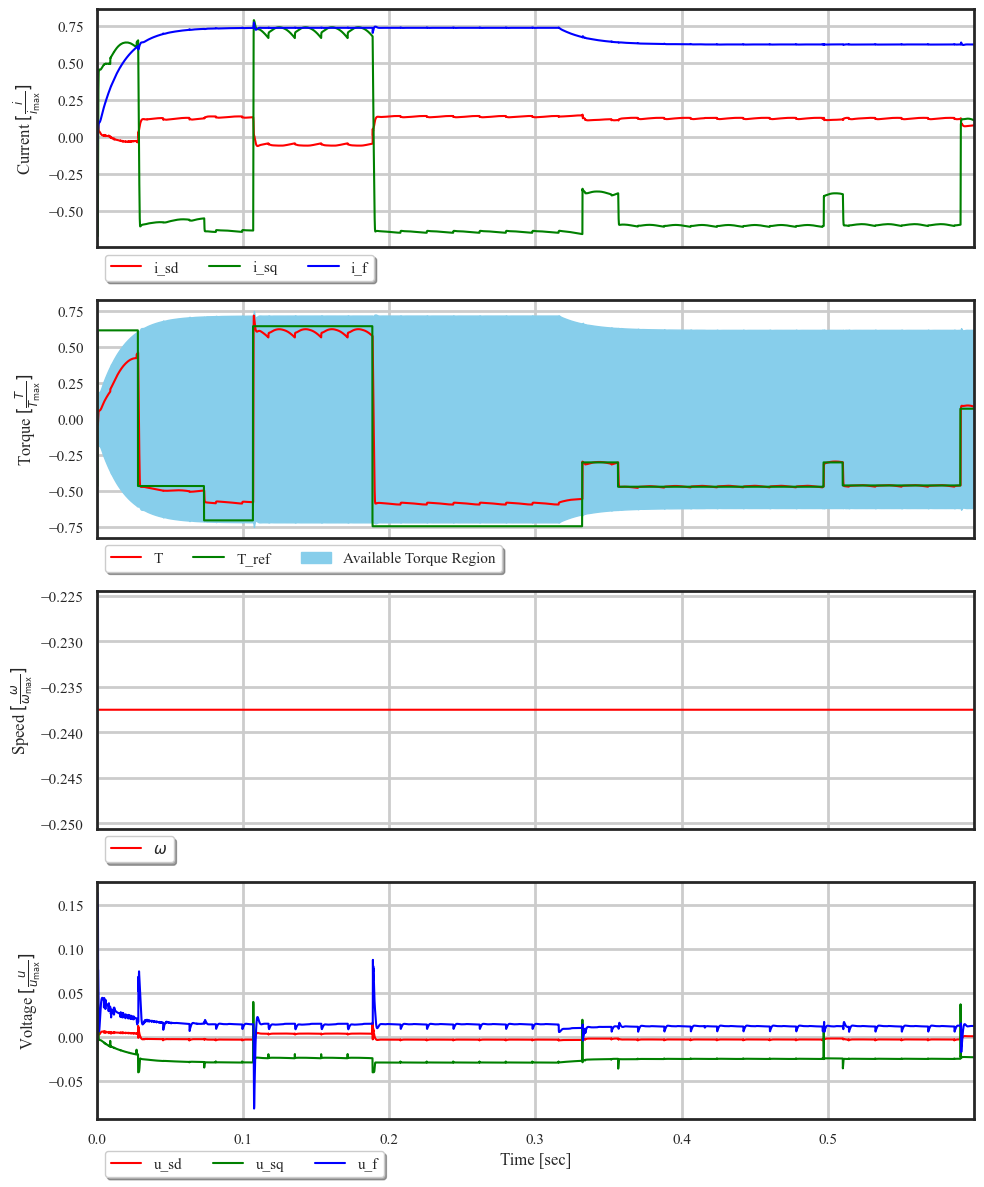

In [19]:
sampling = 1e-4
time_points = range(len(i_sd))
time_duration = np.arange(0, len(i_sd), 1000)
time_sec = (time_duration * sampling).round(2)

import seaborn as sns
sns.set_theme(context='notebook', style='white', palette='deep', font='Times New Roman', font_scale=1, color_codes=True, rc={'axes.linewidth': 2, 'grid.linewidth': 2})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12), sharex=True)

ax1.plot(time_points, i_sd, label='i_sd', color = 'red')
ax1.plot(time_points, i_sq, label='i_sq', color = 'green')
ax1.plot(time_points, i_f, label = 'i_f', color = 'blue')
ax1.set_ylabel(r'Current $[\frac{i}{i_{\text{max}}}]$')
ax1.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol = 3)
ax1.grid()

ax2.plot(time_points, torque, label='T', color = 'red')
ax2.plot(time_points, torque_ref, label='T_ref', color = 'green')
ax2.fill_between(time_points, Tem_pos_nom, Tem_neg_nom, label = 'Available Torque Region', color = 'skyblue')
ax2.set_ylabel(r'Torque $[\frac{T}{T_{\text{max}}}]$')
ax2.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol=3)
ax2.grid()

ax3.plot(time_points, omegas, label = r'$\omega$', color = 'red')
ax3.set_ylabel(r'Speed $[\frac{\omega}{\omega_{\text{max}}}]$')
ax3.legend(loc='upper left', bbox_to_anchor=(0, 0),
          fancybox=True, shadow=True, ncol = 1)
ax3.grid()

ax4.plot(time_points, action_record[:,0], label='u_sd', color='red')
ax4.plot(time_points, action_record[:,1], label='u_sq', color='green')
ax4.plot(time_points, action_record[:,2], label='u_f', color='blue')
ax4.set_ylabel(r'Voltage $[\frac{u}{u_{\text{max}}}]$')
ax4.set_xlabel('Time [sec]')
# ax4.set_ylim([-1,1])
ax4.set_xlim([0, len(i_sd)])
ax4.legend(loc='upper left', bbox_to_anchor=(0, -0.1),
          fancybox=True, shadow=True, ncol = 3)
ax4.grid()
ax4.set_xticks(time_duration, time_sec)
# ax5.set_ylim([-1.5, 1.5])
# Adjust layout
plt.tight_layout()
plt.show()